# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [ ]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Download and visualise the imaging dataset.

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [ ]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2024-02-24 11:31:44--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2024-02-24 11:31:45--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a3affedbab9cfb15ce79feb04.dl.dropboxusercontent.com/cd/0/inline/CN7N9T7fN4MiBJY_O5uHc7t3M3FhM7DGldKu4d1U74ezHwZQ6L4oYzmuXFJviF8YbHvkihTVKAjum5wGYzQnBTzAs4cVfNmejBhVYhSVhs8V9o43oYjpGT8Aq2aTNaxLBlE/file# [following]
--2024-02-24 11:31:45--  https://uc2a3affedbab9cfb15ce79feb04.dl.dropboxusercontent.com/cd/0/inline/CN7N9T7fN4MiBJY_O5uHc7t3M3FhM7DGldKu4d1U74ezHwZQ6L4oYzmuXFJviF8YbHvkihTV

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

<ipython-input-3-6a1154997c19>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  original_image = imageio.imread(original_image_path)
<ipython-input-3-6a1154997c19>:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  segmentation_image = imageio.imread(segmentation_image_path)


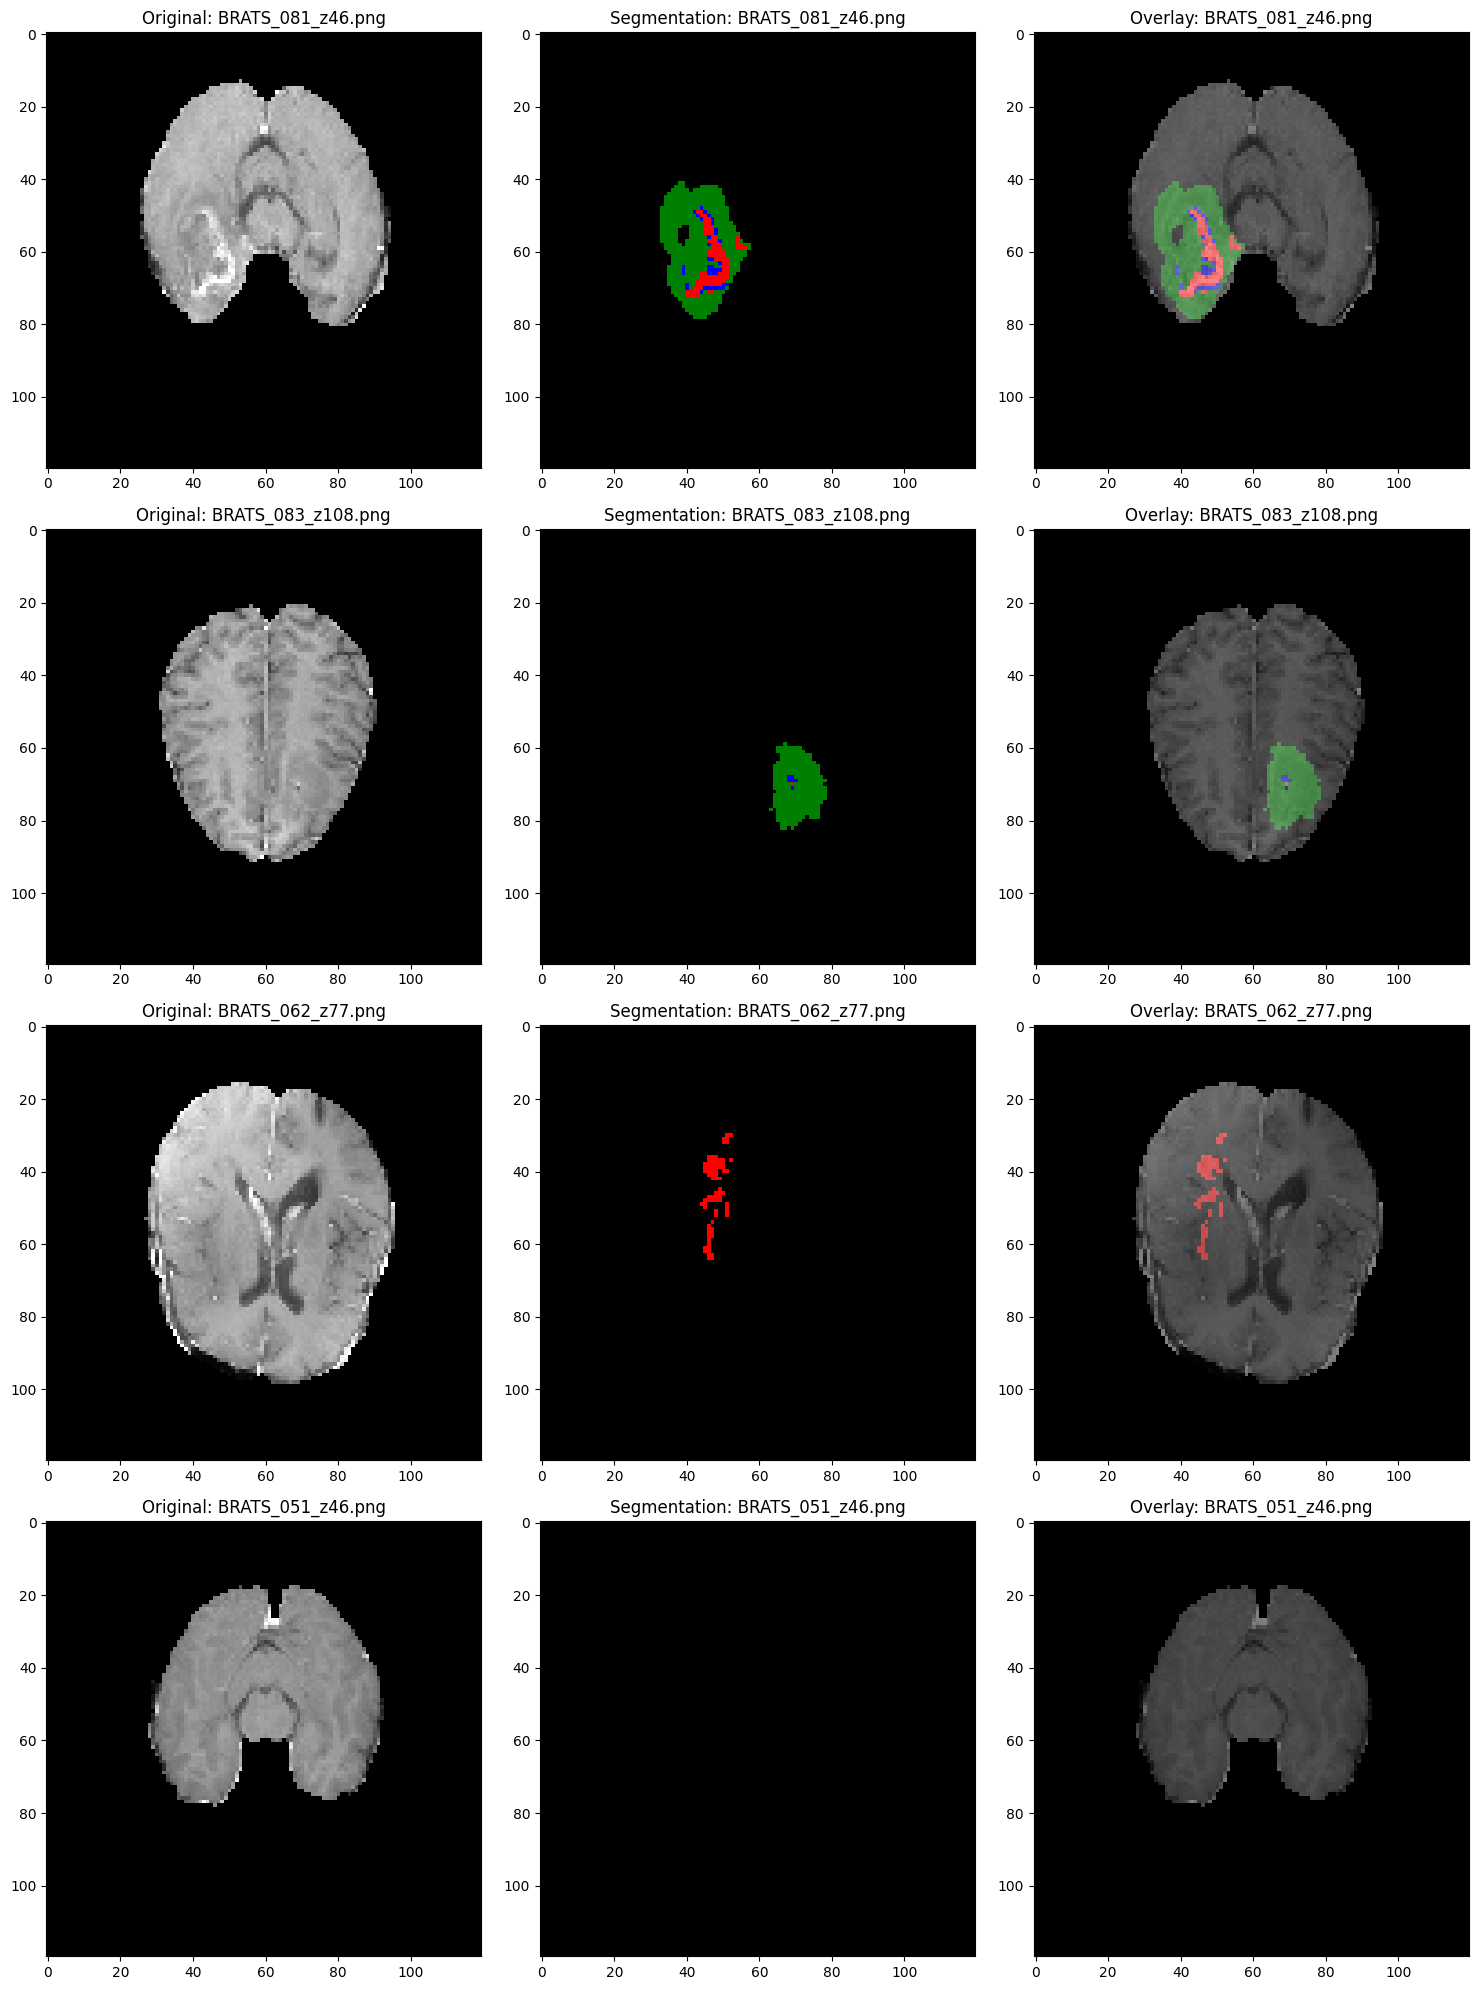

In [ ]:
def load_images(paths, count=4):
    # Adjust subplot setup for original, segmentation, and overlay in separate columns
    fig, axes = plt.subplots(count, 3, figsize=(15, count * 5))  # 3 columns for each type

    label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

    for i in range(count):
        # Randomly select an image index for this row
        image_files = os.listdir(paths[0])
        length = len(image_files)
        index = random.randint(0, length - 1)

        # Load and display the original image
        original_image_path = os.path.join(paths[0], image_files[index])
        original_image = imageio.imread(original_image_path)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f"Original: {image_files[index]}")

        # Load and display the segmentation map
        segmentation_image_path = os.path.join(paths[1], image_files[index])
        segmentation_image = imageio.imread(segmentation_image_path)
        axes[i, 1].imshow(segmentation_image, cmap=label_cmap)
        axes[i, 1].set_title(f"Segmentation: {image_files[index]}")

        # Overlay the segmentation map on the original image
        axes[i, 2].imshow(original_image, cmap='gray', alpha = 1)
        axes[i, 2].imshow(segmentation_image, cmap=label_cmap, alpha=0.5)  # Set alpha value here
        axes[i, 2].set_title(f"Overlay: {image_files[index]}")

    plt.tight_layout()
    plt.show()

# Example usage
paths = ["./Task01_BrainTumour_2D/training_images", "./Task01_BrainTumour_2D/training_labels"]
count = 4
load_images(paths, count)

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [ ]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]

        return image, label



    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###

        # Select unique random indices, assuming len(self) > batch_size
        indexes = np.random.choice(len(self), batch_size, replace=False)
        for idx in indexes:
            # Fetch and normalize image, fetch label
            image, label = self[idx]
            images.append(image)
            labels.append(label)

        # Convert lists to NumPy arrays and add channel dimension to images
        images = np.array(images).reshape((-1, 1, images[0].shape[0], images[0].shape[1]))
        labels = np.array(labels)

        ### End of your code ###
        return images, labels

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path

        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        # Decoder path
        ### Insert your code ###

        # Define the up-convolutions
        self.upconv4 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_after_upconv4 = self.make_layer(n, n // 2)

        n = n // 2
        self.upconv3 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_after_upconv3 = self.make_layer(n, n // 2)

        n = n // 2
        self.upconv2 = nn.ConvTranspose2d(n, n // 2, kernel_size=2, stride=2)
        self.conv_after_upconv2 = self.make_layer(n, n // 2)

        # Final 1x1 convolution to get to the desired output_channel size
        self.final_conv = nn.Conv2d(num_filter, output_channel, kernel_size=1)


    def make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        ### End of your code ###

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        ### Insert your code ###
        # Do the 2x2 kernel convolution then concatentate with other layer
        x = self.upconv4(x)
        x = torch.cat((x, conv3_skip), dim=1)
        x = self.conv_after_upconv4(x)

        x = self.upconv3(x)
        x = torch.cat((x, conv2_skip), dim=1)
        x = self.conv_after_upconv3(x)

        x = self.upconv2(x)
        x = torch.cat((x, conv1_skip), dim=1)
        x = self.conv_after_upconv2(x)

        # The final 1 by 1 convolution
        x = self.final_conv(x)

        ### End of your code ###
        return x

## 4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits,labels)

    if it % 100 == 0:
        print("Iteration: {} Training Loss: {:.4f}".format(it, loss.item()))

    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            images, labels = test_set.get_random_batch(train_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits,labels)
            if it %1000 == 0:
              print(f'Test set loss: {loss.item()}')
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

Device: cuda


<ipython-input-4-f3f4d955d06e>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(image_path, image_name))
<ipython-input-4-f3f4d955d06e>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  label = imageio.imread(label_name)


Iteration: 100 Training Loss: 0.4538
Iteration: 200 Training Loss: 0.1610
Iteration: 300 Training Loss: 0.1207
Iteration: 400 Training Loss: 0.0777
Iteration: 500 Training Loss: 0.0939
Iteration: 600 Training Loss: 0.0603
Iteration: 700 Training Loss: 0.0457
Iteration: 800 Training Loss: 0.0405
Iteration: 900 Training Loss: 0.0418
Iteration: 1000 Training Loss: 0.0471
Test set loss: 0.05314449220895767
Iteration: 1100 Training Loss: 0.0377
Iteration: 1200 Training Loss: 0.0298
Iteration: 1300 Training Loss: 0.0378
Iteration: 1400 Training Loss: 0.0436
Iteration: 1500 Training Loss: 0.0332
Iteration: 1600 Training Loss: 0.0273
Iteration: 1700 Training Loss: 0.0344
Iteration: 1800 Training Loss: 0.0277
Iteration: 1900 Training Loss: 0.0267
Iteration: 2000 Training Loss: 0.0290
Test set loss: 0.026385430246591568
Iteration: 2100 Training Loss: 0.0187
Iteration: 2200 Training Loss: 0.0216
Iteration: 2300 Training Loss: 0.0173
Iteration: 2400 Training Loss: 0.0269
Iteration: 2500 Training L

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

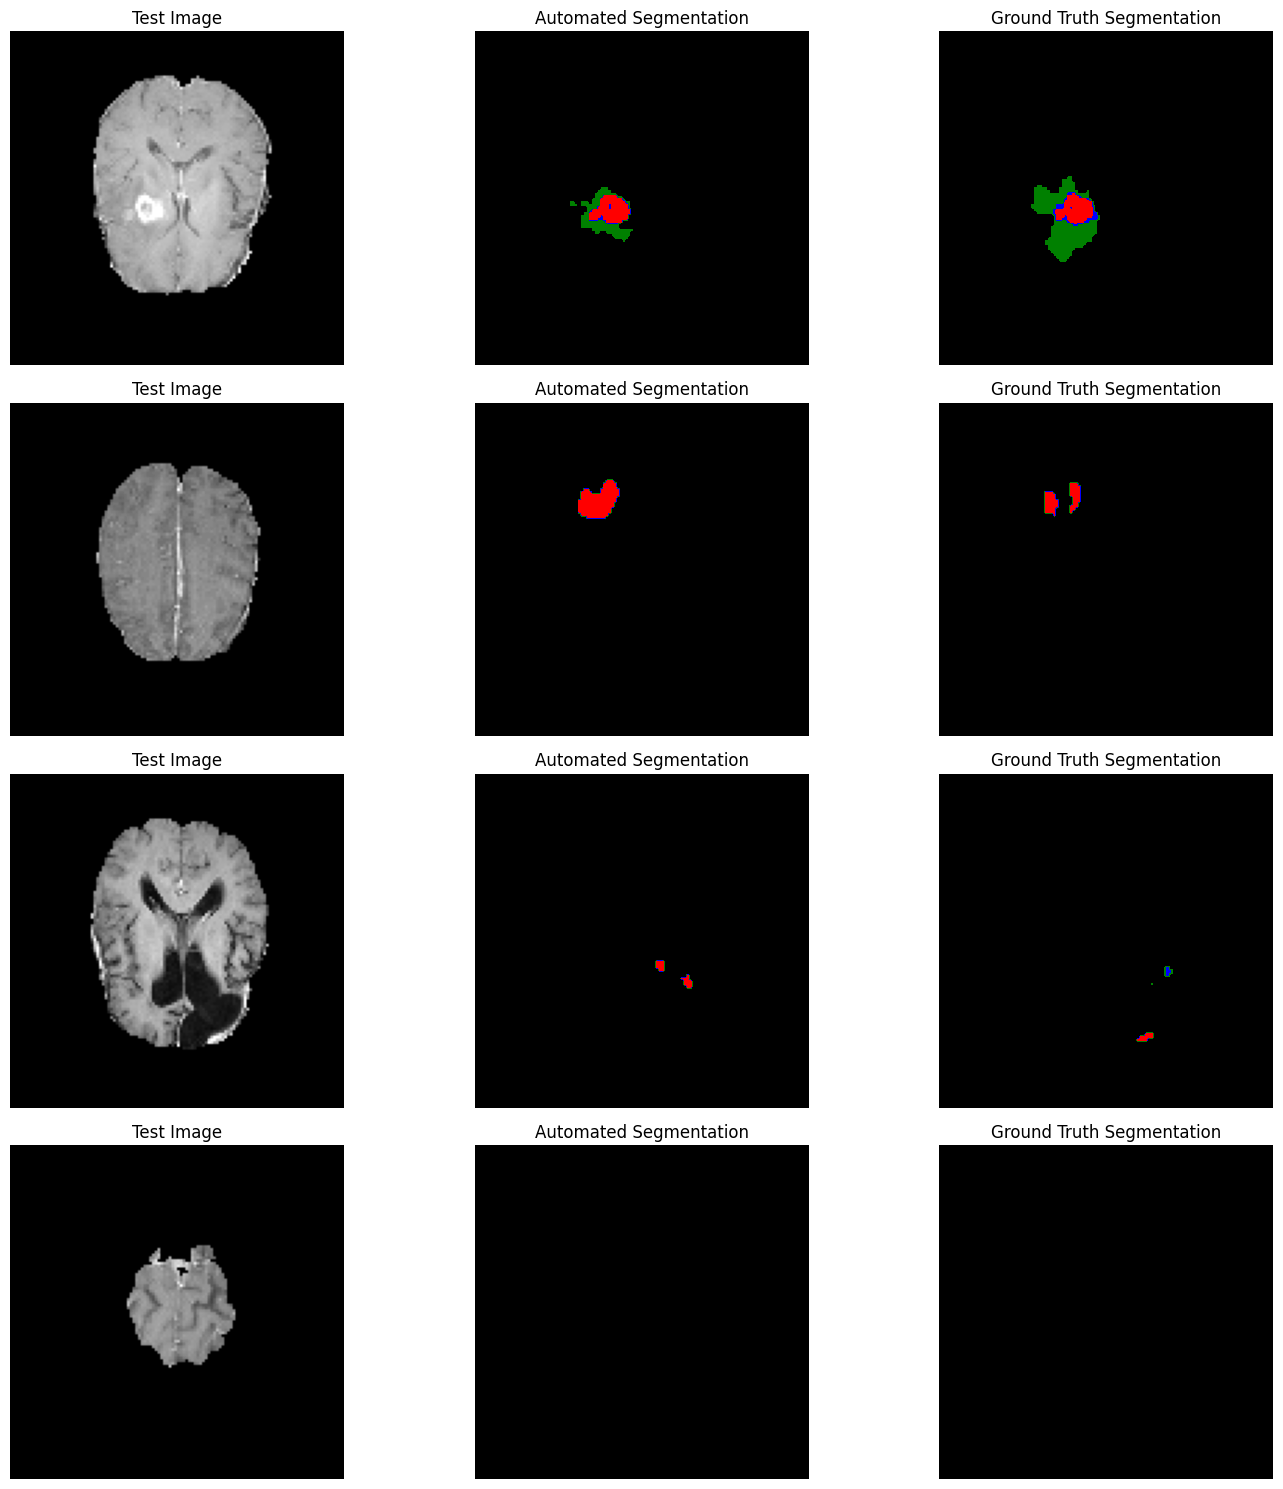

In [ ]:
### Insert your code ###
### Model load and evaluation ###
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "saved_models/model_10000.pt"
test_model = UNet(input_channel=1, output_channel=4, num_filter=16)
checkpoint = torch.load(model_path, map_location=device)
test_model.load_state_dict(checkpoint)
test_model.to(device)
test_model.eval()

count = 4

### get a batch ###
images, labels = test_set.get_random_batch(count)
images = torch.from_numpy(images).to(device, dtype=torch.float32)
labels = torch.from_numpy(labels).to(device, dtype=torch.long)

### generate predictions ###
with torch.no_grad():  # Ensure no gradients are computed to save memory and computations
    logits = test_model(images)

### data for visualisation ###
# Convert logits to predicted labels
predicted_labels = torch.argmax(logits, dim=1)

### Move images, predicted labels, and true labels to CPU ###
images_cpu = images.cpu().numpy()
predicted_labels_cpu = predicted_labels.cpu().numpy()
labels_cpu = labels.cpu().numpy()

# Reshape images for display if necessary (assuming single-channel grayscale images)
images_cpu = images_cpu.reshape(images_cpu.shape[0], images_cpu.shape[2], images_cpu.shape[3])

### Display ###
def display_segmentations(images, predictions, labels, count=4):
    # Ensure matplotlib uses the ListedColormap for segmentation maps
    label_cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

    fig, axes = plt.subplots(count, 3, figsize=(15, 15))  # 4 rows, 3 columns

    for i in range(count):
        # Display Test Image
        axes[i, 0].imshow(images[i], cmap='gray')
        # axes[i, 0].set_title(f'Test Image: {images[i]}')
        axes[i, 0].set_title('Test Image')
        axes[i, 0].axis('off')

        # Display Automated Segmentation
        axes[i, 1].imshow(predictions[i], cmap=label_cmap)
        axes[i, 1].set_title('Automated Segmentation')
        axes[i, 1].axis('off')

        # Display Ground Truth Segmentation
        axes[i, 2].imshow(labels[i], cmap=label_cmap)
        axes[i, 2].set_title('Ground Truth Segmentation')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with prepared data
display_segmentations(images_cpu, predicted_labels_cpu, labels_cpu, count=count)

### End of your code ###

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The visual outputs from the trained model indicate a promising direction in automated segmentation of brain MRI for identifying various types of brain tumours. The model has successfully identified regions of edema (green), non-enhancing tumour (blue), and enhancing tumour (red) with respect to the ground truth, albeit with some discrepancies. Notably, the absence of false negatives—regions of interest that are incorrectly marked as background—is particularly encouraging, as it suggests a high sensitivity of the model. The rate of false positives appears low, which is critical for clinical applications to avoid unnecessary interventions.

Nonetheless, there are areas where refinement is necessary. The underestimation of edema clusters and the smoothing of intricate contours imply a need for improved feature extraction, possibly through advanced convolutional filters or layers that capture fine-grained details without compromising generalisation. Post-processing techniques like Conditional Random Fields (CRFs) could also enhance segmentation fidelity, particularly in rendering the irregular shapes of pathological regions.

For clinical deployment, addressing the model's tendency to conflate tumour types is crucial, given the significant variations in treatment pathways, especially for the typically more aggressive enhancing tumours. To mitigate potential overfitting from extensive iterations, dropout layers and early stopping should be integrated, rather than stopping after 10,000 iterations. Dropout layers will encourage the network to develop a more robust and redundant representation of the data by preventing over-reliance on specific neurons, which is crucial for a network with relatively few layers that may be prone to high bias and underfitting. Hyperparameter tuning, informed by a validation set, of the type of adaptive learning rate utilised, the dropout layer percentage, and early stopping criteria could help optimise accuracy, precision, and recall across the segmentation classes. Additionally, adopting data augmentation, attention mechanisms, and exploring deeper architectures may enhance performance. Furthermore, connecting more previous outputs from the encoding layers like in UNet++ could be an avenue to explore, or a more extreme change would be using a transformer-based model instead.

Robust validation is key before clinical adoption can be considered; this includes not only qualitative visual assessment but also a rigorous statistical analysis of segmentation metrics against medical benchmarks. Metrics like accuracy, precision, and recall must be computed for each class in the segmentation, with particular attention to class imbalance. The model's interpretability and adaptability to diverse clinical imaging settings are also paramount. Only with a thorough validation that confirms the model's reliability can it be integrated into clinical workflows and used to support medical decision-making


